In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.ensemble import HistGradientBoostingRegressor as hgbr
from sklearn.metrics import r2_score as r2 
import shap, datetime,warnings
warnings.filterwarnings('ignore')

In [9]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_finance.pkl', 'rb'))

In [10]:
sentiment_cols = [i for i in df.columns if any(x in i for x in ['Article Count', 'Tone', 'llm'])] + [i for i in df.columns if i.startswith('c') or i.startswith('v')]
time_cols = ['hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10','month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8','month_of_year_9','day_of_week_0','day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4']
self_finance_vars = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and all(x not in i for x in ['BNO','JETS','IYT','ITA'])]
oil_vars          = [i for i in df.columns if 'lag' in i and 'BNO' in i]
etf_finance_vars  = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and any(x in i for x in ['JETS','IYT','ITA'])]
finance_vars = self_finance_vars + oil_vars + etf_finance_vars

In [11]:
# Define the different sets of features to try
feature_sets = {
    'time_only': time_cols,
    'sentiment_only': sentiment_cols,
    'self_finance_only': self_finance_vars,
    'finance_only': finance_vars,
    'finance_time': finance_vars + time_cols,
    'all': sentiment_cols + finance_vars + time_cols 
}

In [12]:
y_cols = ['Volume']
y = df[y_cols]

In [13]:
# Train/test splitting
split_val  = round(0.8 * len(y))
split_test = round(0.9 * len(y))

y_train = y[:split_val]
y_val   = y[split_val:split_test]
y_test  = y[split_test:]

In [14]:
for feature_set in feature_sets:
    print(f'Processing feature set: {feature_set}')

    x_cols = feature_sets[feature_set]
    x = df[x_cols]
    x_train = x[:split_val]
    x_val   = x[split_val:split_test]
    x_test  = x[split_test:]

    # Normalize the features to [0,1]
    sc2 = MinMaxScaler(feature_range=(0, 1))

    x_train = sc2.fit_transform(x_train)
    x_val   = sc2.transform(x_val)
    x_test  = sc2.transform(x_test)

    model = hgbr(
        learning_rate=0.01,
        min_samples_leaf=200,
        l2_regularization=0,
        max_features=1.0,
        max_leaf_nodes=None,
        max_depth=None,
        early_stopping=True,
        scoring='r2',
        n_iter_no_change=10,
        verbose=2,
        max_iter = 2000,
        random_state=42
    )

    model.fit(x_train, y_train, X_val=x_val, y_val=y_val)
    pickle.dump(model, open(f'../../output/models/lightgbm/lightgbm_{feature_set}.pkl', 'wb'))
    print(f"{model.score(x_val, y_val)}, {model.score(x_test, y_test)}")

Processing feature set: time_only
Binning 0.056 GB of training data: 0.081 s
Binning 0.007 GB of validation data: 0.002 s
Fitting gradient boosted rounds:
[1/2000] 1 tree, 402 leaves, max depth = 22, train score: 0.00165, val score: 0.00096, in 0.051s
[2/2000] 1 tree, 404 leaves, max depth = 22, train score: 0.00330, val score: 0.00304, in 0.058s
[3/2000] 1 tree, 404 leaves, max depth = 22, train score: 0.00493, val score: 0.00508, in 0.058s
[4/2000] 1 tree, 404 leaves, max depth = 22, train score: 0.00652, val score: 0.00708, in 0.052s
[5/2000] 1 tree, 404 leaves, max depth = 22, train score: 0.00809, val score: 0.00904, in 0.051s
[6/2000] 1 tree, 404 leaves, max depth = 22, train score: 0.00962, val score: 0.01097, in 0.052s
[7/2000] 1 tree, 404 leaves, max depth = 22, train score: 0.01113, val score: 0.01286, in 0.050s
[8/2000] 1 tree, 404 leaves, max depth = 22, train score: 0.01260, val score: 0.01471, in 0.054s
[9/2000] 1 tree, 404 leaves, max depth = 22, train score: 0.01405, va

In [235]:
y_pred = model.predict(x_val)
y_pred = np.where(y_pred < 0, 0, y_pred)  # Ensure no negative predictions
y_pred = pd.Series(y_pred, index=y_val.index)

In [236]:
df_results = df.copy()
df_results = df_results.iloc[y_val.index,:]
df_results['y_pred'] = y_pred
df_results['residuals'] = df_results['Volume'] - df_results['y_pred']
df_results

,date,ticker,Article Count_cum04_lag01,Article Count_cum16_lag01,Article Count_cum48_lag01,Article Count_cum96_lag01,Article Count_lag01,Article Count_lag02,Article Count_lag04,Article Count_lag16,...,sentiment_pca_295,sentiment_pca_296,sentiment_pca_297,sentiment_pca_298,sentiment_pca_299,sentiment_pca_300,sentiment_pca_301,sentiment_pca_302,y_pred,residuals
270085,2023-12-04 14:00:00,ALK,18,77,173,641,3,10,3,5,...,0.565441,-0.304639,-0.546424,0.632031,-1.452355,0.617390,0.804562,-0.292800,373182.114979,-40160.114979
270086,2023-12-04 14:00:00,DAL,2,13,29,64,1,0,1,1,...,-0.036747,0.025630,0.284650,-0.014649,0.013367,0.413924,0.281589,0.155326,139824.694034,-68701.694034
270087,2023-12-04 14:00:00,JBLU,7,31,79,415,2,2,2,1,...,-0.056143,0.425695,0.169083,0.239773,-1.072194,0.300906,0.210888,0.111098,326501.062243,107874.937757
270088,2023-12-04 14:00:00,LUV,2,14,30,60,1,1,0,1,...,0.075383,0.127710,0.428332,-0.095260,-0.175509,0.255340,0.264124,-0.044858,169909.156937,-25086.156937
270089,2023-12-04 14:00:00,UAL,2,12,33,79,1,0,1,1,...,-0.030756,0.309050,0.646624,-0.592963,-0.284221,-0.123344,0.856093,-0.063437,175926.512986,-66168.512986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303840,2024-08-30 13:30:00,ALGT,0,0,1,2,0,0,0,0,...,-0.029826,0.018689,0.026539,-0.008435,0.012484,0.033309,0.022581,-0.036260,11795.437107,-10011.437107
303841,2024-08-30 13:30:00,ALK,2,6,22,74,1,1,0,0,...,0.032163,-0.034872,-0.086550,0.020872,0.201903,-0.292822,-0.170083,0.078381,35110.443331,-19807.443331
303842,2024-08-30 13:30:00,DAL,1,7,11,50,1,0,0,0,...,-0.294496,0.574377,-0.171782,0.288191,0.104103,-0.328650,0.220003,0.176544,93185.412105,-32055.412105
303843,2024-08-30 13:30:00,JBLU,5,16,36,85,2,2,0,0,...,0.127846,-0.144088,0.180996,0.040980,0.101481,-0.413499,0.046071,0.022465,332187.214920,-185443.214920


In [237]:
for i in df['ticker'].unique():
    vals = df.iloc[y_val.index,:][df['ticker'] == i].index
    print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')

AAL: 0.626
ALGT: 0.458
ALK: 0.650
DAL: 0.693
JBLU: 0.587
LUV: 0.529
UAL: 0.744


In [238]:
df['time_of_day'] = df['date'].dt.time

for i in np.sort(df['time_of_day'].unique()):
    vals = df.iloc[y_val.index,:][df['time_of_day'] == i].index
    print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')

09:30:00: 0.307
09:45:00: 0.655
10:00:00: 0.797
10:15:00: 0.828
10:30:00: 0.857
10:45:00: 0.724
11:00:00: 0.778
11:15:00: 0.759
11:30:00: 0.821
11:45:00: 0.739
12:00:00: 0.808
12:15:00: 0.777
12:30:00: 0.736
12:45:00: 0.417
13:00:00: 0.617
13:15:00: 0.838
13:30:00: 0.816
13:45:00: 0.730
14:00:00: 0.731
14:15:00: 0.774
14:30:00: 0.743
14:45:00: 0.816
15:00:00: 0.726
15:15:00: 0.756
15:30:00: 0.767
15:45:00: 0.767


In [195]:
df['day_of_week'] = df['date'].dt.day_of_week

for i in np.sort(df['day_of_week'].unique()):
    vals = df.iloc[y_val.index,:][df['day_of_week'] == i].index
    print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')

0: 0.733
1: 0.729
2: 0.728
3: 0.774
4: 0.761


In [200]:
df['month_of_year'] = df['date'].dt.month

for i in np.sort(df['month_of_year'].unique()):
    try:
        vals = df.iloc[y_val.index,:][df['month_of_year'] == i].index
        print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')
    except Exception:
        pass

1: 0.727
2: 0.822
3: 0.745
4: 0.804
5: 0.692
6: 0.719
7: 0.754
8: 0.700
12: 0.804


In [188]:
np.sort(df['time_of_day'].unique())

array([datetime.time(9, 30), datetime.time(9, 45), datetime.time(10, 0),
       datetime.time(10, 15), datetime.time(10, 30),
       datetime.time(10, 45), datetime.time(11, 0), datetime.time(11, 15),
       datetime.time(11, 30), datetime.time(11, 45), datetime.time(12, 0),
       datetime.time(12, 15), datetime.time(12, 30),
       datetime.time(12, 45), datetime.time(13, 0), datetime.time(13, 15),
       datetime.time(13, 30), datetime.time(13, 45), datetime.time(14, 0),
       datetime.time(14, 15), datetime.time(14, 30),
       datetime.time(14, 45), datetime.time(15, 0), datetime.time(15, 15),
       datetime.time(15, 30), datetime.time(15, 45)], dtype=object)

In [137]:
plot_data = pd.merge(plot_data, pd.DataFrame(y_pred, columns=['y_pred']), left_index=True, right_index=True)

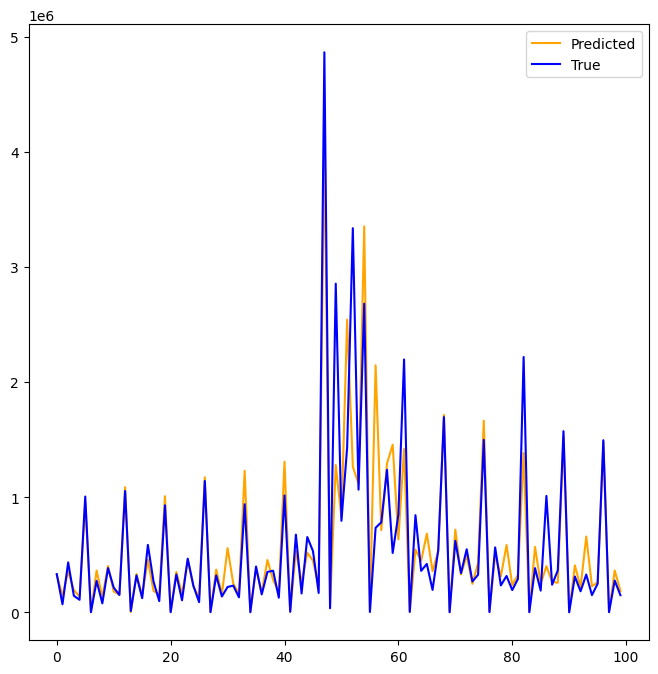

In [138]:
filter_data = plot_data.iloc[:100,:]

plt.figure(figsize=(8, 8))
plt.plot(filter_data.index, filter_data['y_pred'], label='Predicted', color='orange')
plt.plot(filter_data.index, filter_data['Volume'], label='True', color='blue')
plt.legend()

C:\Users\Steven\AppData\Local\Temp\ipykernel_1220\2646763451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['residuals'] = filter_data['AAL_Volume'] - filter_data['y_pred']


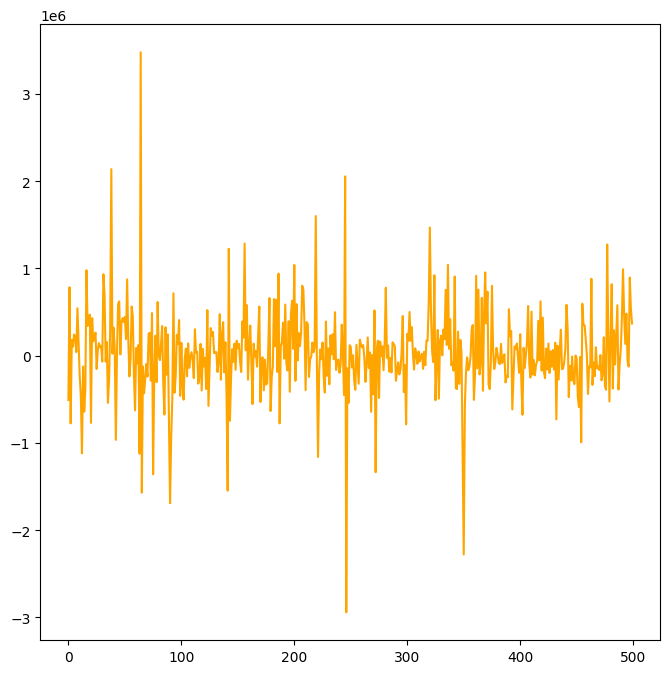

In [165]:
filter_data = plot_data.iloc[:500,:]
filter_data['residuals'] = filter_data['AAL_Volume'] - filter_data['y_pred']

plt.figure(figsize=(8, 8))
plt.plot(filter_data.index, filter_data['residuals'], label='residuals', color='orange')